#Effective Stiffness 

##Introduction

This example uses the MKSHomogenizationModel to create a homogenization linkage for the effective stiffness. This example starts with a brief background of the homogenization theory on the components of the effective elastic stiffness tensor for a composite material. Then the example generates random microstructures and their average stress values that will be used to show how to calibrate and use our model. We will also show how to use tools from [sklearn](http://scikit-learn.org/stable/) to optimize fit parameters for the MKSHomogenizationModel. Lastly, the data is used to evaluate the MKSHomogenizationModel for effective stiffness values for a new set of microstructures.


## Linear Elasticity and Effective Elastic Modulus

For this example we are looking to create a homogenization linkage that predicts the effective isotropic stiffness components for two-phase microstructures. The specific stiffness component we are looking to predict in this example is $C_{xxxx}$ which is easily accessed by applying an uniaxial macroscal strain tensor (the only non-zero component is $\varepsilon_{xx}$. 

$$ u(L, y) = u(0, y) + L\bar{\varepsilon}_{xx}$$

$$ u(0, L) = u(0, 0) = 0  $$

$$ u(x, 0) = u(x, L) $$

More details about these boundary conditions can be found in [1]. Using these boundary conditions, $C_{xxxx}$ can be estimated calculating the ratio of the averaged stress over the applied averaged strain.

$$ C_{xxxx}^* \cong  \bar{\sigma}_{xx} / \bar{\varepsilon}_{xx}$$ 

In this example, $C_{xxxx}$ for 6 different types of microstructures will be estimated using the `MKSHomogenizationModel` from `pymks`, and provides a method to compute $\bar{\sigma}_{xx}$ for a new microstructure with an applied strain of $\bar{\varepsilon}_{xx}$.


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

## Data Generation

A set of periodic microstructures and their volume averaged elastic stress values $\bar{\sigma}_{xx}$ can be generated by importing the `make_elastic_stress_random` function from `pymks.datasets`. This function has several arguments. `n_samples` is the number of samples that will be generated, `size` specifies the dimensions of the microstructures, `grain_size` controls the effective microstructure feature size, `elastic_modulus` and `poissons_ratio` are used to indicate the material property for each of the
phases, `macro_strain` is the value of the applied uniaxixial strain, and the `seed` can be used to change the the random number generator seed.

Let's go ahead and create 6 different types of microstructures each with 200 samples with dimensions 21 x 21. Each of the 6 samples will have a different microstructure feature size. The function will return and the microstructures and their associated volume averaged stress values.


In [2]:
from pymks.datasets import make_elastic_stress_random
sample_size = 200
grain_size = [(15, 2), (2, 15), (7, 7), (8, 3), (3, 9), (2, 2)]
n_samples = [sample_size] * 6
elastic_modulus = (410, 200)
poissons_ratio = (0.28, 0.3)
macro_strain = 0.001
size = (21, 21)

X, y = make_elastic_stress_random(n_samples=n_samples, size=size, grain_size=grain_size, 
                                      elastic_modulus=elastic_modulus, poissons_ratio=poissons_ratio, 
                                      macro_strain=macro_strain, seed=0)


The array `X` contains the microstructure information and has the dimensions 
of `(n_samples, Nx, Ny)`. The array `y` contains the average stress value for 
each of the microstructures and has dimensions of `(n_samples,)`.


In [3]:
print(X.shape)
print(y.shape)

(1200, 21, 21)
(1200,)


Lets take a look at the 6 types the microstructures to get an idea of what they 
look like. We can do this by importing `draw_microstructures`. 


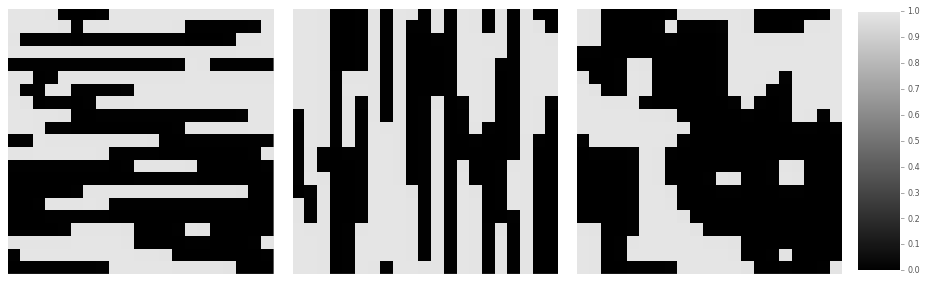

In [4]:
from pymks.tools import draw_microstructures
X_examples = X[::sample_size]
draw_microstructures((X_examples[:3]))

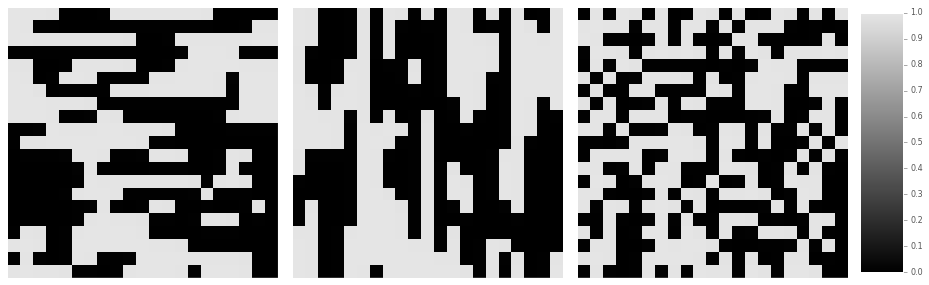

In [5]:
draw_microstructures((X_examples[3:]))

In this dataset 4 of the 6  microstructure types have grains that are elongated in either
the x or y directions. The remaining 2 types of samples have equiaxed grains with
different average sizes.

Let's look at the stress values for each of the microstructures shown above.


In [6]:
print('Stress Values'), (y[::200])

Stress Values [ 0.30279774  0.27063703  0.30712908  0.29559632  0.28195039  0.28474614]


Now that we have a dataset to work with, we can look at how to use the `MKSHomogenizationModel`to predict stress values for new microstructures.


## MKSHomogenizationModel Work Flow

The default instance of the MKSHomogenizationModel takes in a dataset and 
 - calculates the 2-point statistics
 - performs [dimensionality reduction](http://en.wikipedia.org/wiki/Dimensionality_reduction) using [Singular Valued Decomposition](http://en.wikipedia.org/wiki/Singular_value_decomposition) (SVD)
 - and fits a [polynomial regression model](http://en.wikipedia.org/wiki/Polynomial_regression) model to the low-dimensional representation.

This work flow has been shown to accurately predict effective properties in several examples [2][3], and requires that we specify the number of components used in dimensionality reduction and the order of the polynomial we will be using for the polynomial regression. In this example we will show how we can use tools from [sklearn](http://scikit-learn.org/stable/) to try and optimize our selection for these two parameters.


##Modeling with MKSHomogenizationModel

In order to make an instance of the MKSHomogenizationModel, we need to pass an instance of a basis (used to compute the 2-point statistics). For this particular example, there are only 2 discrete phases, so we will use the `PrimitiveBasis` from `pymks`. We only have two phases denoted by 0 and 1, therefore we have two local states and our domain is 0 to 1.

Let's make an instance of the MKSHomgenizationModel.


In [7]:
from pymks import MKSHomogenizationModel
from pymks import PrimitiveBasis

prim_basis = PrimitiveBasis(n_states=2, domain=[0, 1])
model = MKSHomogenizationModel(basis=prim_basis, 
                               correlations=[(0, 0), (1, 1), (0, 1)])

Let's take a look at the default values for the number of components and the order of the polynomial.

In [8]:
print('Default Number of Components'), (model.n_components)
print('Default Polynomail Order'), (model.degree)

Default Number of Components 2
Default Polynomail Order 1


These default parameters may not be the best model for a given problem, we will now show one method that can be used to optimize them.


## Optimizing the Number of Components and Polynomial Order

To start with, we can look at how the variance changes as a function of the number of components.
In general for SVD as well as PCA, the amount of variance captured in each component decreases
as the component number increases.
This means that as the number of components used in the dimensionality reduction increases, the percentage of the variance will asymptotically approach 100%. Let's see if this is true for our dataset.

In order to do this we will change the number of components to 40 and then
fit the data we have using the `fit` function. This function performs the dimensionality reduction and 
also fits the regression model. Because our microstructures are periodic, we need to 
use the `periodic_axes` argument when we `fit` the data.


In [9]:
model.n_components = 40
model.fit(X, y, periodic_axes=[0, 1])

Now look at how the cumlative variance changes as a function of the number of components using `draw_component_variance` 
from `pymks.tools`.


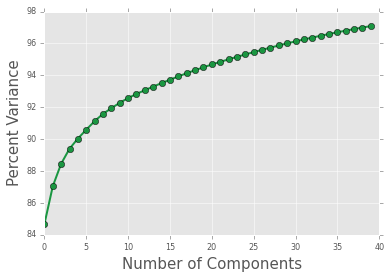

In [10]:
from pymks.tools import draw_component_variance

draw_component_variance(model.dimension_reducer.explained_variance_ratio_)

Roughly 90 percent of the variance is captured with the first 5 components. This means our model may only need a few components to predict the average stress.

Next we need to optimize the number of components and the polynomial order. To do this we are going to split the data into testing and training sets. This can be done using the [train_test_spilt](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) function from sklearn.


In [11]:
from sklearn.cross_validation import train_test_split

flat_shape = (X.shape[0],) + (np.prod(X.shape[1:]),)

X_train, X_test, y_train, y_test = train_test_split(X.reshape(flat_shape), y,
                                                    test_size=0.2, random_state=3)
print(X_train.shape)
print(X_test.shape)

(960, 441)
(240, 441)


We will use cross validation with the testing data to fit a number 
of models, each with a different number 
of components and a different polynomial order.
Then we will use the testing data to verify the best model. 
This can be done using [GridSeachCV](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) 
from sklearn.

We will pass a dictionary `params_to_tune` with the range of
polynomial order `degree` and components `n_components` we want to try.
A dictionary `fit_params` can be used to pass the `periodic_axes` variable to 
calculate periodic 2-point statistics. The argument `cv` can be used to specify 
the number of folds used in cross validation and `n_jobs` can be used to specify 
the number of jobs that are ran in parallel.

Let's vary `n_components` from 1 to 7 and `degree` from 1 to 3.


In [12]:
from sklearn.grid_search import GridSearchCV

params_to_tune = {'degree': np.arange(1, 4), 'n_components': np.arange(1, 8)}
fit_params = {'size': X[0].shape, 'periodic_axes': [0, 1]}
gs = GridSearchCV(model, params_to_tune, cv=12, n_jobs=6, fit_params=fit_params).fit(X_train, y_train)

The default `score` method for the MKSHomogenizationModel is the [R-squared](http://en.wikipedia.org/wiki/Coefficient_of_determination) value. Let's look at the how the mean R-squared values and their 
standard deviations change as we varied the number of `n_components` and `degree` using
`draw_gridscores_matrix` from `pymks.tools`.


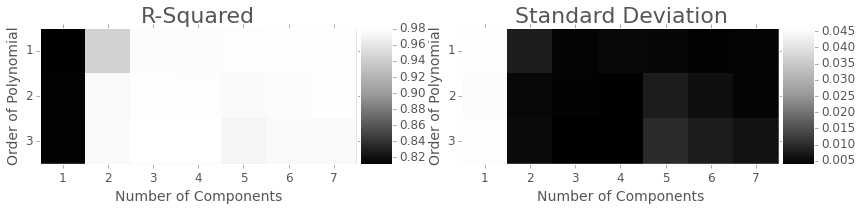

In [13]:
from pymks.tools import draw_gridscores_matrix

draw_gridscores_matrix(gs, ['n_components', 'degree'], score_label='R-Squared',
                       param_labels=['Number of Components', 'Order of Polynomial'])

It looks like we get a poor fit when only the first and second component are used, and when we increase
the polynomial order and the components together. The models have a high standard deviation and 
poor R-squared values for both of these cases.

There seems to be several potential models that use 3 to 6 components. It's difficult to see which model 
is the best. Let's use our testing data `X_test` to see which model performs the best.


In [14]:
print('Order of Polynomial'), (gs.best_estimator_.degree)
print('Number of Components'), (gs.best_estimator_.n_components)
print('R-squared Value'), (gs.score(X_test, y_test))

Order of Polynomial 3
Number of Components 3
R-squared Value 0.982073916103


For the parameter range that we searched, we have found that a model with 3rd order polynomial 
and 3 components had the best R-squared value. It's difficult to see the differences in the score
values and the standard deviation when we have 3 or more components. Let's take a closer look at those values using `draw_grid_scores`.


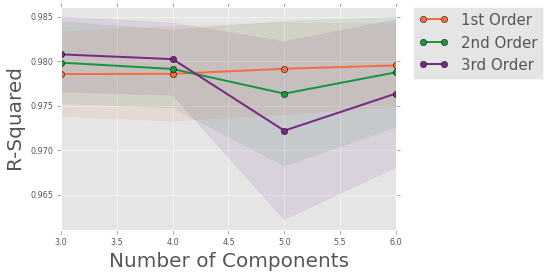

In [15]:
from pymks.tools import draw_gridscores

gs_deg_1 = [x for x in gs.grid_scores_ \
            if x.parameters['degree'] == 1][2:-1]
gs_deg_2 = [x for x in gs.grid_scores_ \
            if x.parameters['degree'] == 2][2:-1]
gs_deg_3 = [x for x in gs.grid_scores_ \
            if x.parameters['degree'] == 3][2:-1]

draw_gridscores([gs_deg_1,  gs_deg_2, gs_deg_3], 'n_components', 
                data_labels=['1st Order', '2nd Order', '3rd Order'], 
                colors=['#f46d43', '#1a9641', '#762a83'],
                param_label='Number of Components', score_label='R-Squared')

As we said, a model with a 3rd order polynomial and 3 components will give us the best result,
but there are several other models that will likely provide comparable results. Let's make the
best model from our grid scores.


In [16]:
model = gs.best_estimator_

##Prediction using MKSHomogenizationModel

Now that we have selected values for `n_components` and `degree`, lets fit the model with the data. Again because
our microstructures are periodic, we need to use the `periodic_axes` argument.


In [17]:
model.fit(X, y, periodic_axes=[0, 1])

Let's generate some more data that can be used to try and validate our model's prediction accuracy. We are going to
generate 20 samples of all six different types of microstructures using the same 
`make_elastic_stress_random` function.


In [18]:
test_sample_size = 20
n_samples = [test_sample_size] * 6
X_new, y_new = make_elastic_stress_random(n_samples=n_samples, size=size, grain_size=grain_size, 
                                          elastic_modulus=elastic_modulus, poissons_ratio=poissons_ratio, 
                                          macro_strain=macro_strain, seed=1)

Now let's predict the stress values for the new microstructures. 


In [19]:
y_predict = model.predict(X_new, periodic_axes=[0, 1])

We can look to see if the low-dimensional representation of the 
new data is similar to the low-dimensional representation of the data 
we used to fit the model using `draw_components` from `pymks.tools`.


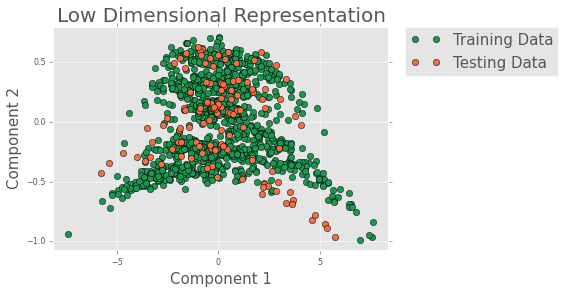

In [20]:
from pymks.tools import draw_components

draw_components([model.reduced_fit_data[:, :2], 
                 model.reduced_predict_data[:, :2]],
                ['Training Data', 'Testing Data'])

The predicted data seems to be reasonably similar to the data we used to fit the model
with. Now let's look at the score value for the predicted data.


In [21]:
from sklearn.metrics import r2_score
print('R-squared'), (model.score(X_new, y_new, periodic_axes=[0, 1]))

R-squared 0.99834842402


Looks pretty good. Let's print out one actual and predicted stress value for each of the 6 microstructure types to see how they compare.


In [22]:
print('Actual Stress   '), (y_new[::20])
print('Predicted Stress'), (y_predict[::20])

Actual Stress    [ 0.28985647  0.2831434   0.25138814  0.29399186  0.26338502  0.27548337]
Predicted Stress [ 0.29038894  0.28375754  0.25230674  0.29388488  0.26327469  0.27586485]


Lastly, we can also evaluate our prediction by looking at a goodness-of-fit plot. We
can do this by importing `draw_goodness_of_fit` from `pymks.tools`.


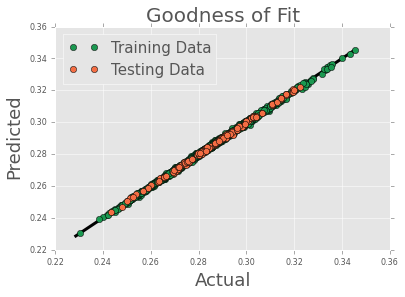

In [23]:
from pymks.tools import draw_goodness_of_fit

fit_data = np.array([y, model.predict(X, periodic_axes=[0, 1])])
pred_data = np.array([y_new, y_predict])
draw_goodness_of_fit(fit_data, pred_data, ['Training Data', 'Testing Data'])

We can see that the MKSHomogenizationModel has created a homogenization linkage for the effective stiffness for the 6 different microstructures and has predicted the average stress values for our new microstructures reasonably well.


##References

[1] Landi, G., S.R. Niezgoda, S.R. Kalidindi, Multi-scale modeling of elastic response of three-dimensional voxel-based microstructure datasets using novel DFT-based knowledge systems. Acta Materialia, 2009. 58 (7): p. 2716-2725 [doi:10.1016/j.actamat.2010.01.007](http://dx.doi.org/10.1016/j.actamat.2010.01.007).

[2] Çeçen, A., et al. "A data-driven approach to establishing microstructure–property relationships in porous transport layers of polymer electrolyte fuel cells." Journal of Power Sources 245 (2014): 144-153. [doi:10.1016/j.jpowsour.2013.06.100](http://dx.doi.org/10.1016/j.jpowsour.2013.06.100)

[3] Deshpande, P. D., et al. "Application of Statistical and Machine Learning Techniques for Correlating Properties to Composition and Manufacturing Processes of Steels." 2 World Congress on Integrated Computational Materials Engineering. John Wiley & Sons, Inc.  [doi:10.1002/9781118767061.ch25](http://dx.doi.org/10.1002/9781118767061.ch25)
